## Native integration DataRobot and Snowflake Snowpark: Maximizing the data cloud

Author: Atalia Horenshtien

Version Date: April 6 2023

### Overview

This notebook showcase the native integration between DataRobot and Snowflake teh data cloud via the DataRobot API and Snowflake, leveraging DataRobot notebooks and Snowflake Snowpark (Python + Java)

#### DataRobot
You will leverage DataRobot ML experimentation: DataRobot hosted notebooks, AutoML, model selection, insights and explainability, and ML productions: single shop for deployment and model monitoring.

#### Snowflake
You will leverage Snowflake for data storage and Snowpark for deployment, feature engineering, and model scoring. facilitate datasource access and utilize the Spark backbone to perform distributed scoring to support large-scale use cases.

The dataset for this project is a 'Fraud Detection' use case and the notebook was created from a DataRobot Notebook - hosted notebooks, jupyter compatible, and supporting preloaded packages and Python and R syntax.
DataRobot hosted Notebooks can also be used for code-snippets, versioning, and simple environment management for rapid AI experimentation, increasing your productivity.

### This notebook covers the following steps:

1. Load data to Snowflake from an S3 file
2. Acquiring a training dataset from a snowflake table using Snowpark for Python
3. Feature engineering - analyzing data and creating new features using Snowpark for Python
4. Building a new DataRobot project
5. Analyzing and evaluating model performance and explainability using DataRobo AutoML
6. Deploying the recommended model to Snowflake using DataRobot MLOps
7. Scoring model via Snowpark for Java
8. Monitor model using DataRobot MLOps

### Before execution 
* Make sure the environment is Python 3.8
* Configure the following environmental variables (users credentials to Snowflake):
    'snowflake_user' - your snowflake's user name
    'snowflake_password' - your snowflake's password
    'snowflake_accoutnt' - your snowflake's account name

Most of the project is executed by the notebook, creating a deployment and a monitoring job should be configured via the DataRobot GUI - supporting docs and steps are in the notebook along the way.

#### Setup

In [1]:
#if needed install the following:
!pip install Flask-SQLAlchemy
!pip install --upgrade snowflake-sqlalchemy

     |████████████████████████████████| 624kB 82.1MB/s 


     |████████████████████████████████| 1.6MB 36.2MB/s 


  Found existing installation: SQLAlchemy 2.0.9


    Uninstalling SQLAlchemy-2.0.9:
      Successfully uninstalled SQLAlchemy-2.0.9


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
import seaborn as sns
import json
import os
from pathlib import Path
from sqlalchemy import create_engine

from datarobot.enums import CHART_DATA_SOURCE, DATA_DRIFT_METRIC
from datarobot.models.project import Project
from datarobot.models.deployment import Deployment, FeatureDrift
from datarobot.models.prediction_server import PredictionServer


#from datarobot.models import FeatureDrift

import snowflake.connector
from snowflake.connector.pandas_tools import pd_writer
from snowflake.snowpark.functions import udf, col, call_udf
from snowflake.snowpark import Session

from datetime import datetime

from sqlalchemy.dialects import registry
registry.register('snowflake', 'snowflake.sqlalchemy', 'dialect')
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from snowflake.sqlalchemy import URL
import urllib.parse


In [ ]:

snowflake_password = os.environ['snowflake_password']
snowflake_user = os.environ['snowflake_user']
snowflake_account = os.environ['snowflake_account']


In [ ]:
#these are the details, no need to change.

database_name = "SANDBOX"
schema_name = "FINANCE"
warehouse_name = "DEMO_WH"

In [5]:
#load training data - 'Fraud Detection' from S3 to Snowflake 
safe_password_string = urllib.parse.quote_plus(snowflake_password)

conn_string = (
    f"snowflake://{snowflake_user}:{safe_password_string}@{snowflake_account}/{database_name}"
)

engine = create_engine(conn_string)

# %%

engine.execute(
    '''
    CREATE SCHEMA IF NOT EXISTS FINANCE;
    
    
    ''')
    
renamer = {'date':'DATE_COLUMNS'}
pd.read_csv("https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/FRAUD_DETECTION_TRAINING.csv").rename(columns=renamer).to_sql(name="fraud_detection_training", schema=schema_name, con=engine, if_exists='replace' , method=pd_writer, index=False )




# %


/tmp/ipykernel_25/4281520494.py:12: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  engine.execute(


In [ ]:
CONNECTION_PARAMETERS = {
   "account": snowflake_account,
   "user": snowflake_user,
   "password": snowflake_password,
   "database": database_name,
   "schema": schema_name,
   "warehouse": warehouse_name
}

#### Data Preparation 

I’m going to use Snowpark for feature engineering. 
Snowpark is a developer framework where I can work on a familiar syntax, in this example Python. Snowpark pushes down processing to Snowflake to run consistently in a highly secure and elastic engine.

In [ ]:
#Here I am creating the ‘session’ object that represents Snowpark and a dataframe that references the data in Snowflake.

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [ ]:
df_train = session.table("FRAUD_DETECTION_TRAINING")

In [9]:
df_train.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ISFRAUD"  |"TRNX_ID"   |"CITY"         |"SHIPPING_ZIPCODE"  |"SHIPPING_STATE"  |"IS_OVERNIGHT_SHIPPING"  |"PAYMENT_NETWORK"  |"PAYMENT_TYPE"  |"AVG_TRNX_AMOUNT_PER_ITEM"  |"TOTAL_TRNX_AMOUNT"  |"PROMO_CODE"  |"GUEST_CHECKOUT"  |"ACCOUNT_CHECKOUT"  |"IS_NIGHT_ORDER"  |"EMAIL_ON_FILE"  |"SESSION_LENGTH_IN_MINS"  |"COOKIE_IS_SEEN_BEFORE"  |"IS_BROWSER_LANGUAGE_TRANSLATED"  |"l_6KhI_IP_ADDRESS"    |"CSRNOTES"                                          |"r_torw_IP_ADDR

In [ ]:
# Snowpark - Create an instance of UserDefinedFunction using the @udf decorator
@udf

#define the function: args: WHOLE_WEIGHT, HEIGHT
def is_long_session (session_length_in_mins: float) -> bool:
    if session_length_in_mins > 20:
        return 1
    else: 
        return 0
    

In [ ]:
# Snowpark call UDFs on a dataframe, calculation in snowflake
udf_df_train = df_train.select(col('*'), is_long_session(col("SESSION_LENGTH_IN_MINS")).alias("LONG_SESSION"))

In [ ]:
udf_df_train.write.mode("overwrite").save_as_table("FRAUD_DETECTION_TRAINING")

In [ ]:
#Snowpark supports Pandas
df_train_pd = df_train.toPandas()

<AxesSubplot: xlabel='ISFRAUD', ylabel='count'>

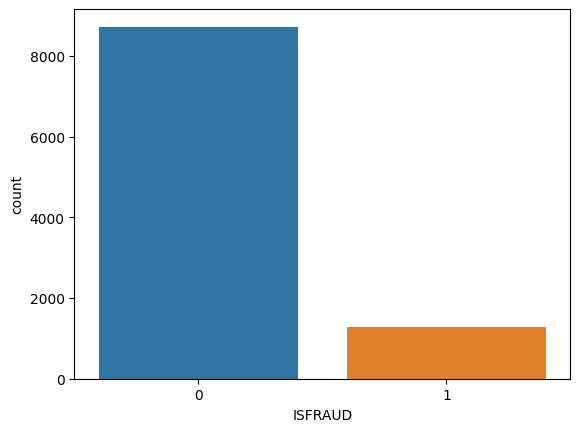

In [14]:
sns.countplot(data = df_train_pd
            ,x = 'ISFRAUD'
            )

#### Model Training 

Here we leverage DataRobot’s AutoML capabilities, including explainability and compliance documentation to speed up the model’s results and regulatory compliance.

In [ ]:
# Optional - If you already run autopilot before - get the project by replacing the ID
#project = Project.get('63853765cfc79e4555fa2537')

In [ ]:
#defining project name and current date
now = datetime.now().strftime('%Y-%m-%dT%H:%M')
project = Project.create(df_train_pd,
                            project_name='Fraud_detection_{}'.format(now))

In [ ]:
#setting the target variable and ready to go!
project.analyze_and_model(target = 'ISFRAUD',                                     # setting project target
                       mode = 'quick',                                        # setting up project run mode, leaving in auto
                       worker_count = -1,                                    # assigning worker count, -1 will use all available
                       max_wait=24*60*60                                     # time series projects can take a little more time to get through EDA2 than normal AutoML projects
                      )

In [ ]:
#This (optional) will block execution of the notebook until the full autopilot process has completed. This can take several minutes or hours, depending on the autopilot mode selected, the size of the dataset, and the type of problem we're trying to solve.

project.wait_for_autopilot()

In [16]:
#This output a list of all the models trained in the project, sorted by the selected validation metric.

project.get_models()[:10]

[Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('AVG Blender'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping with Bias Mitigation Reweighing using CITY (excluded as predictor variable)'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping')]

In [ ]:
# Get the most accurate model based on the project's metric - DataRobot provides a recommendation for an accurate and performant model at the end of training process
most_accurate_model = project.get_top_model()

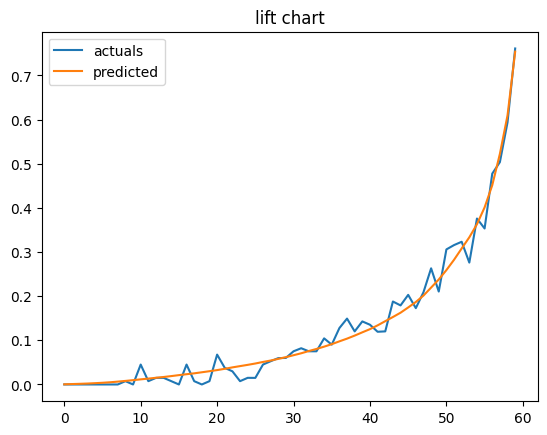

In [18]:
# Evaluate the model using a lift chart
plot = most_accurate_model.get_lift_chart('crossValidation')
df = pd.DataFrame.from_dict(plot.bins)

# create data
x = df.index
y = df['actual']
y2 = df['predicted']
  
# plot lines
plt.plot(x, y, label = "actuals")
plt.plot(x, y2, label = "predicted")
plt.legend()
plt.title('lift chart')
plt.show()

(0.0, 1.0)

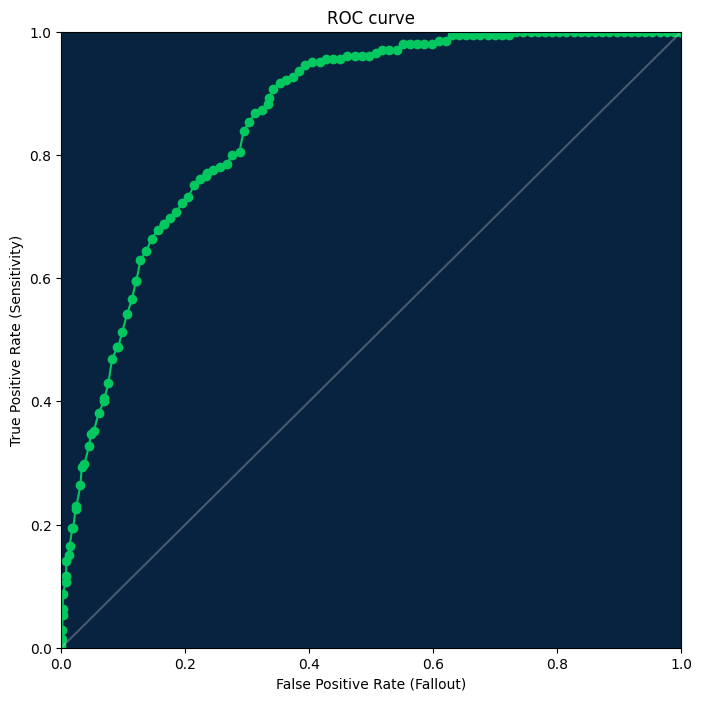

In [19]:
# Evaluate the model using ROC Curve

# Get the ROC curve
roc = most_accurate_model.get_roc_curve(source=CHART_DATA_SOURCE.VALIDATION)

# Save the result into a Pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)
roc_df.head()

# Set chart colors
dr_roc_green = "#03c75f"
white = "#ffffff"
dr_purple = "#65147D"
dr_dense_green = "#018f4f"
dr_dark_blue = "#08233F"

# Create chart
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)
plt.scatter(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)

# Format chart
plt.title("ROC curve")
plt.xlabel("False Positive Rate (Fallout)")
plt.xlim([0, 1])
plt.ylabel("True Positive Rate (Sensitivity)")
plt.ylim([0, 1])


<AxesSubplot: xlabel='featureName', ylabel='impactNormalized'>

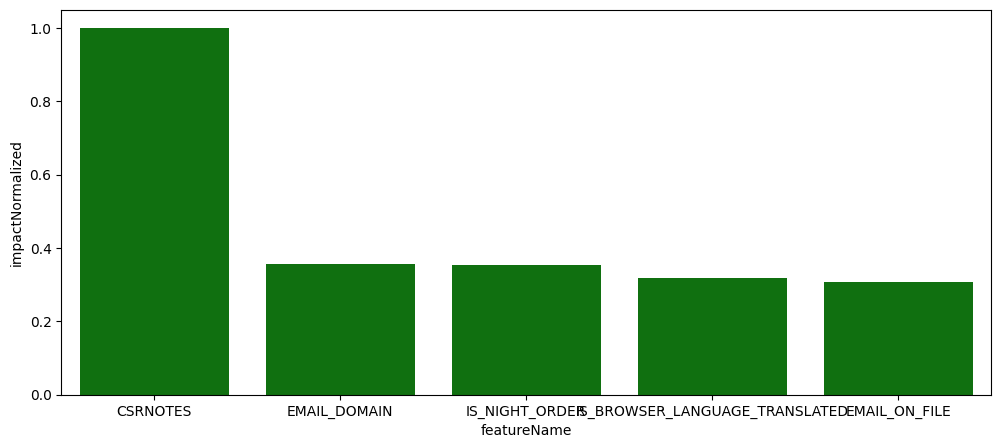

In [20]:
# Getting insights on which feature driving model's outcome

# Get Feature Impact
feature_impact = most_accurate_model.get_or_request_feature_impact()

# Save feature impact in pandas dataframe
fi_df = pd.DataFrame(feature_impact)

# Plot the top 5 most impactful features
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="featureName", y="impactNormalized", data=fi_df[0:5], color="g")


#### Model Deploymnet

To deploy to snowflake you need to do it through the DataRobot GUI:
Create a snowflake prediction environment and deployment : https://docs.datarobot.com/en/docs/mlops/mlops-preview/pp-snowflake-sc-deploy-replace.html




In [21]:
#get the deployed model - change ID to your deployment
deployment = Deployment.get('6413a07ea0a9ee22d203464b')
deployment

Deployment(ISFRAUD Predictions)

In [22]:
#Let's create the scoring data
#an example for subset data, for convenience 
query = " create or replace table FRAUD_DETECTION_SCORING as " +\
        "  select * from FRAUD_DETECTION_TRAINING limit 10 "
        
session.sql(query).collect()

[Row(status='Table FRAUD_DETECTION_SCORING successfully created.')]

In order to score the data in Snowflake we will leverage Snowpark for JAVA.

Go to the created deployment > 'Predictions' tab > from section 2. copy the signature of the function and replace it in the next section. 

Example:
query = " SELECT *, scoring_code_udf_schema.replace_function_name_here(OBJECT_CONSTRUCT_KEEP_NULL(*)) " +\
        " FROM FRAUD_DETECTION_SCORING "

In [23]:
#score new data

query = " CREATE OR REPLACE TABLE FRAUD_DETECTION_SCORING as" +\
        " SELECT *, datarobot_deployment_642adf008b22ed8d5de483ba(OBJECT_CONSTRUCT_KEEP_NULL(*)) as model_score FROM FRAUD_DETECTION_SCORING;"

        
session.sql(query).collect()

[Row(status='Table FRAUD_DETECTION_SCORING successfully created.')]

In [24]:
#store results and modify columns names

query = " CREATE OR REPLACE TABLE FRAUD_DETECTION_SCORING as select *, model_score:\"0\"::float false_fraud, model_score:\"1\"::float true_fraud  from FRAUD_DETECTION_SCORING; "

session.sql(query).collect()

  

[Row(status='Table FRAUD_DETECTION_SCORING successfully created.')]

In [25]:
# Convert session object to a DF

df_scored = session.table("FRAUD_DETECTION_SCORING")
df_scored_pd = df_scored.toPandas()
df_scored_pd

ISFRAUD     TRNX_ID           CITY  SHIPPING_ZIPCODE SHIPPING_STATE  \
0        0  0A2NFUEAXK       Bellevue             98006             WA   
1        0  06SZBVOBLR      Lafayette             97127             OR   
2        0  00RR895EU3         Austin             78701             TX   
3        0  0B0O8C6XZK       Pasadena             91102             CA   
4        0  01U36CAPW2          Ocala             34477             FL   
5        0  0BV263UCKP     Birmingham             35201             AL   
6        0  08VKKHGKB3       Scranton             18502             PA   
7        0  032DNL6Z4Q   Collinsville             62234             IL   
8        0  053KCN1AHF      Manhattan             10024             NY   
9        1  04FHTCOJNI  Atlantic City              8404             NJ   

   IS_OVERNIGHT_SHIPPING PAYMENT_NETWORK PAYMENT_TYPE  \
0                  False        Discover        Debit   
1                  False        Discover       Credit   
2                  False            Amex       Credit   
3                  False     Diners Club        Debit   
4                  False            Visa       Credit   
5                  False           Other       Credit   
6                  False      Mastercard       Credit   
7                  False        Discover       Credit   
8                  False             JCB        Debit   
9                   True      Mastercard       Credit   

   AVG_TRNX_AMOUNT_PER_ITEM  TOTAL_TRNX_AMOUNT  ...  \
0                127.068541             127.07  ...   
1                 21.233044              63.70  ...   
2                 61.301199             122.60  ...   
3                189.088667             945.44  ...   
4                 85.521290              85.52  ...   
5                138.408627             692.04  ...   
6                 50.424195             100.85  ...   
7                 76.885533             230.66  ...   
8                 21.652255              43.30  ...   
9                175.038967             525.12  ...   

  IS_BROWSER_LANGUAGE_TRANSLATED      l_6KhI_IP_ADDRESS  \
0                          False          39.65.126.156   
1                          False  2001:1890:1340:c200::   
2                          False        172.242.112.120   
3                           True         66.214.150.236   
4                          False          71.214.86.145   
5                          False         75.231.114.132   
6                          False           174.59.4.112   
7                          False          68.75.121.108   
8                          False         63.112.187.128   
9                          False           68.85.145.39   

                                            CSRNOTES      r_torw_IP_ADDRESS  \
0                                                             39.65.126.156   
1                                                     2001:1890:1340:c200::   
2                                                           172.242.112.120   
3                                                            66.214.150.236   
4  duplicated order, returned customer, order sti...          71.214.86.145   
5                                                            75.231.114.132   
6                                                              174.59.4.112   
7                                                             68.75.121.108   
8                                                            63.112.187.128   
9  service request, verified customer,   IP Black...           68.85.145.39   

   EMAIL_DOMAIN  NUMBER_SESSION_FROM_IP_PAST_24HR  LONG_SESSION  \
0   outlook.com                               0.0         False   
1     gmail.com                               0.0         False   
2     yahoo.com                               1.0         False   
3   yopmail.com                               0.0         False   
4     gmail.com                               0.0         False   
5    xmaily.com                 

We can see the predictions in the last two columns

#### Model Monitoring

To make sure business decisions are aligned with external and internal factors, we need to monitor the model performance and understand if the mnodel needs to be replaced or retrained. To define a monitoring job, please check this doc: https://docs.datarobot.com/en/docs/mlops/mlops-preview/pp-monitoring-jobs.html

Once the monitoring job has bee executed we can see data drift and accuracy either in the UI, either using the API.


In [26]:
#get the target drift

target_drift = deployment.get_target_drift(
    start_time=datetime(2023, 4, 1, hour=15),
    end_time=datetime(2023, 4, 4, hour=15)
)
target_drift.drift_score

8.162262704563577

### Conclusion and Next Steps
DataRobot and Snowflake together offer an end-to-end, enterprise-grade AI experience and expertise to enterprises by reducing complexity and productionizing ML models at scale, unlocking business value.

Visit the website to learn more https://www.datarobot.com/partners/technology-partners/snowflake/